## Note: This is the work I did locally, before moving on to the AWS cluster.

# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [32]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, when, isnull, collect_list
from pyspark.sql.types import IntegerType, BooleanType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [3]:
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Initial Analysis

In [4]:
print((df.count(), len(df.columns)))

(286500, 18)


In [5]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

#### See how many nulls we have

In [6]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
df.select('auth').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [9]:
df.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [9]:
df.select('location').distinct().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [10]:
df.select('page').distinct().show(50)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



### Get rid of unecessary columns:

In [4]:
df_clean = df.select('artist','auth','firstName','gender','lastName','length','level','location','page','song','ts','userId')

In [78]:
df_clean.where((col("page") == "Cancellation Confirmation")).select("userId").distinct().count()

52

In [134]:
df_clean.filter(df_clean.auth=="Cancelled").show()

+------+---------+---------+------+---------+------+-----+--------------------+--------------------+----+-------------+------+
|artist|     auth|firstName|gender| lastName|length|level|            location|                page|song|           ts|userId|
+------+---------+---------+------+---------+------+-----+--------------------+--------------------+----+-------------+------+
|  null|Cancelled|   Adriel|     M|  Mendoza|  null| paid|  Kansas City, MO-KS|Cancellation Conf...|null|1538943990000|    18|
|  null|Cancelled|    Diego|     M|    Mckee|  null| paid|Phoenix-Mesa-Scot...|Cancellation Conf...|null|1539033046000|    32|
|  null|Cancelled|    Mason|     M|     Hart|  null| free|  Corpus Christi, TX|Cancellation Conf...|null|1539318918000|   125|
|  null|Cancelled|Alexander|     M|   Garcia|  null| paid|Indianapolis-Carm...|Cancellation Conf...|null|1539375441000|   105|
|  null|Cancelled|    Kayla|     F|  Johnson|  null| paid|Philadelphia-Camd...|Cancellation Conf...|null|153946

In [5]:
churnedUsers = df_clean.filter(df_clean.auth=="Cancelled")

In [6]:
churnedUsers.select("userId").distinct().count()

52

In [10]:
df_clean.select("userId").distinct().count()

226

In [5]:
df_churn = df_clean.groupby('userId').agg(collect_list('auth').alias("auths"))

In [6]:
churned = udf(lambda x: 'Cancelled' in x)

In [7]:
df_churn = df_churn.withColumn("Churned", churned(df_churn.auths))

In [8]:
df_churn = df_churn.drop('auths')

In [9]:
df_label = df_churn.join(df_clean,'userId')

In [10]:
df_label.show()

+------+-------+--------------------+---------+---------+------+---------+---------+-----+--------------------+-----------+--------------------+-------------+
|userId|Churned|              artist|     auth|firstName|gender| lastName|   length|level|            location|       page|                song|           ts|
+------+-------+--------------------+---------+---------+------+---------+---------+-----+--------------------+-----------+--------------------+-------------+
|100010|  false|Sleeping With Sirens|Logged In| Darianna|     F|Carpenter|202.97098| free|Bridgeport-Stamfo...|   NextSong|Captain Tyin Knot...|1539003534000|
|100010|  false|Francesca Battist...|Logged In| Darianna|     F|Carpenter|196.54485| free|Bridgeport-Stamfo...|   NextSong|Beautiful_ Beauti...|1539003736000|
|100010|  false|              Brutha|Logged In| Darianna|     F|Carpenter|263.13098| free|Bridgeport-Stamfo...|   NextSong|          She's Gone|1539003932000|
|100010|  false|                null|Logged In

In [10]:
df_label.groupby("Churned").avg("length").collect()

[Row(Churned='false', avg(length)=249.20913538880816),
 Row(Churned='true', avg(length)=248.63279564406218)]

In [70]:
df_label.select(["userId","Churned"]).distinct().groupBy("Churned").count().collect()

[Row(Churned='false', count=174), Row(Churned='true', count=52)]

In [38]:
df_label.filter((col('userId')==100003) & (col('song')!='null')).show()

+------+-------+--------------------+---------+---------+------+--------+---------+-----+--------------------+--------+--------------------+-------------+
|userId|Churned|              artist|     auth|firstName|gender|lastName|   length|level|            location|    page|                song|           ts|
+------+-------+--------------------+---------+---------+------+--------+---------+-----+--------------------+--------+--------------------+-------------+
|100003|   true|     Black Eyed Peas|Logged In|   Nevaeh|     F|   Jones|193.88036| free|Miami-Fort Lauder...|NextSong|          Gone Going|1539100420000|
|100003|   true|            Paramore|Logged In|   Nevaeh|     F|   Jones|193.56689| free|Miami-Fort Lauder...|NextSong|All We Know (Albu...|1539100613000|
|100003|   true| A Love Ends Suicide|Logged In|   Nevaeh|     F|   Jones|197.32853| free|Miami-Fort Lauder...|NextSong|     Heroes Of Faith|1539263080000|
|100003|   true|               Stars|Logged In|   Nevaeh|     F|   Jon

In [11]:
df_churn.show()

+------+-------+
|userId|Churned|
+------+-------+
|100010|  false|
|200002|  false|
|   125|   true|
|   124|  false|
|    51|   true|
|     7|  false|
|    15|  false|
|    54|   true|
|   155|  false|
|100014|   true|
|   132|  false|
|   154|  false|
|   101|   true|
|    11|  false|
|   138|  false|
|300017|  false|
|100021|   true|
|    29|   true|
|    69|  false|
|   112|  false|
+------+-------+
only showing top 20 rows



### Number of thumbs up

In [11]:
thumbsUp = df_label.where(df_label.page=='Thumbs Up').groupby("userId").agg(count(col('page')).alias('ThumbsUp')).orderBy('userId')
thumbsUp.show()


+------+--------+
|userId|ThumbsUp|
+------+--------+
|    10|      37|
|   100|     148|
|100001|       8|
|100002|       5|
|100003|       3|
|100004|      35|
|100005|       7|
|100006|       2|
|100007|      19|
|100008|      37|
|100009|      23|
|100010|      17|
|100012|      18|
|100013|      39|
|100014|      17|
|100015|      35|
|100016|      25|
|100017|       2|
|100018|      46|
|100019|       1|
+------+--------+
only showing top 20 rows



### Number of thumbs down

In [12]:

thumbsDown = df_label.where(df_label.page=='Thumbs Down').groupby("userId").agg(count(col('page')).alias('ThumbsDown')).orderBy('userId')
thumbsDown.show()


+------+----------+
|userId|ThumbsDown|
+------+----------+
|    10|         4|
|   100|        27|
|100001|         2|
|100004|        11|
|100005|         3|
|100006|         2|
|100007|         6|
|100008|         6|
|100009|         8|
|100010|         5|
|100011|         1|
|100012|         9|
|100013|        15|
|100014|         3|
|100015|         8|
|100016|         5|
|100017|         1|
|100018|         9|
|100019|         1|
|100021|         5|
+------+----------+
only showing top 20 rows



In [13]:
allThumbs = thumbsUp.join(thumbsDown,'userId')

### Number of songs played

In [14]:
songsPlayed = df_label.where(col('song')!='null').groupby("userId").agg(count(col('song')).alias('SongsPlayed')).orderBy('userId')
songsPlayed.show()



+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



In [15]:
df_features = df_churn.join(songsPlayed,'userId')

In [16]:
df_features = df_features.join(allThumbs,'userId')

In [17]:
df_features.show()

+------+-------+-----------+--------+----------+
|userId|Churned|SongsPlayed|ThumbsUp|ThumbsDown|
+------+-------+-----------+--------+----------+
|100010|  false|        275|      17|         5|
|200002|  false|        387|      21|         6|
|   124|  false|       4079|     171|        41|
|    51|   true|       2111|     100|        21|
|     7|  false|        150|       7|         1|
|    15|  false|       1914|      81|        14|
|    54|   true|       2841|     163|        29|
|   155|  false|        820|      58|         3|
|100014|   true|        257|      17|         3|
|   132|  false|       1928|      96|        17|
|   101|   true|       1797|      86|        16|
|    11|  false|        647|      40|         9|
|   138|  false|       2070|      95|        24|
|300017|  false|       3632|     303|        28|
|100021|   true|        230|      11|         5|
|    29|   true|       3028|     154|        22|
|    69|  false|       1125|      72|         9|
|   112|  false|    

### Days in system

In [18]:
days = df_label.groupby('userId').agg(((max(col('ts')) - min(col('ts')))/86400000).alias("Days"))

In [26]:
days.show()

+------+-------------------+
|userId|               Days|
+------+-------------------+
|100010|  44.21780092592593|
|200002| 45.496805555555554|
|   125|0.02053240740740741|
|   124| 59.996944444444445|
|    51| 15.779398148148148|
|     7| 50.784050925925925|
|    15|  54.77318287037037|
|    54|  42.79719907407407|
|   155|  25.82783564814815|
|100014| 41.244363425925926|
|   132|  50.49740740740741|
|   154| 24.986458333333335|
|   101| 15.861481481481482|
|    11| 53.241585648148146|
|   138|  56.07674768518518|
|300017|  59.11390046296296|
|100021| 45.457256944444445|
|    29|  43.32092592592593|
|    69|  50.98648148148148|
|   112|  56.87869212962963|
+------+-------------------+
only showing top 20 rows



In [19]:
df_features = df_features.join(days, "userId")
df_features.show()

+------+-------+-----------+--------+----------+------------------+
|userId|Churned|SongsPlayed|ThumbsUp|ThumbsDown|              Days|
+------+-------+-----------+--------+----------+------------------+
|100010|  false|        275|      17|         5| 44.21780092592593|
|200002|  false|        387|      21|         6|45.496805555555554|
|   124|  false|       4079|     171|        41|59.996944444444445|
|    51|   true|       2111|     100|        21|15.779398148148148|
|     7|  false|        150|       7|         1|50.784050925925925|
|    15|  false|       1914|      81|        14| 54.77318287037037|
|    54|   true|       2841|     163|        29| 42.79719907407407|
|   155|  false|        820|      58|         3| 25.82783564814815|
|100014|   true|        257|      17|         3|41.244363425925926|
|   132|  false|       1928|      96|        17| 50.49740740740741|
|   101|   true|       1797|      86|        16|15.861481481481482|
|    11|  false|        647|      40|         9|

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [20]:
upPerSong = udf(lambda numUp, songs: numUp/songs, FloatType())

In [21]:
downPerSong = udf(lambda numDown, songs: numDown/songs, FloatType())

In [22]:
songsPerHour = udf(lambda numSongs, numDays: numSongs/(numDays*24), FloatType())

In [23]:
df_features = df_features.drop("UpPerSong", "DownPerSong", "SongsPerHour")

In [24]:
df_features = df_features.withColumn("UpPerSong", upPerSong(df_features.ThumbsUp, df_features.SongsPlayed))

In [25]:
df_features = df_features.withColumn("DownPerSong", downPerSong(df_features.ThumbsDown, df_features.SongsPlayed))

In [26]:

df_features = df_features.withColumn("SongsPerHour", songsPerHour(df_features.SongsPlayed, df_features.Days))

In [27]:
df_features.show()

+------+-------+-----------+--------+----------+------------------+-----------+------------+------------+
|userId|Churned|SongsPlayed|ThumbsUp|ThumbsDown|              Days|  UpPerSong| DownPerSong|SongsPerHour|
+------+-------+-----------+--------+----------+------------------+-----------+------------+------------+
|100010|  false|        275|      17|         5| 44.21780092592593|0.061818182| 0.018181818|  0.25913393|
|200002|  false|        387|      21|         6|45.496805555555554|0.054263566| 0.015503876|  0.35442048|
|   124|  false|       4079|     171|        41|59.996944444444445| 0.04192204| 0.010051483|   2.8327832|
|    51|   true|       2111|     100|        21|15.779398148148148|0.047370914| 0.009947892|   5.5742517|
|     7|  false|        150|       7|         1|50.784050925925925|0.046666667| 0.006666667| 0.123070136|
|    15|  false|       1914|      81|        14| 54.77318287037037| 0.04231975|0.0073145246|   1.4560045|
|    54|   true|       2841|     163|        2

In [71]:
df_features.select("SongsPerHour", "Churned").groupby("Churned").agg(avg(col('SongsPerHour'))).show()

+-------+------------------+
|Churned| avg(SongsPerHour)|
+-------+------------------+
|  false|1.3289544867910115|
|   true| 2.415751496684188|
+-------+------------------+



### Look for correlation between features
Code is from this [Towards Data Science blog post](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

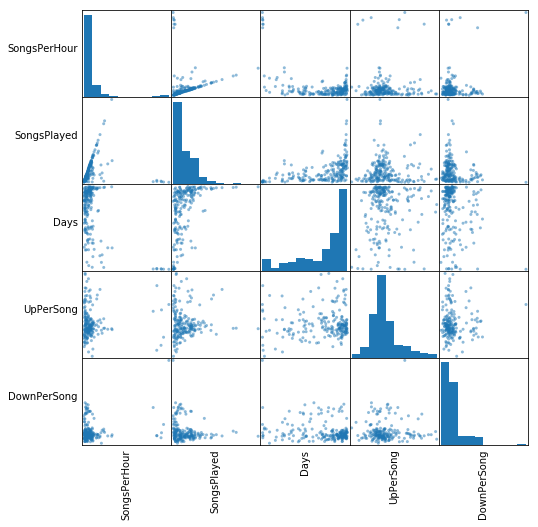

In [33]:
numeric_features = ['SongsPerHour','SongsPlayed','Days','UpPerSong','DownPerSong']
numeric_data = df_features.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

Not unexpectedly, there is correlation between 'songs played' and 'songs per hour'. I have decided to leave both features in, however.

In [84]:
assembler = VectorAssembler(inputCols=["SongsPlayed", "UpPerSong", "DownPerSong", "Days", "SongsPerHour"], outputCol="FeatureVector")
df_features = assembler.transform(df_features)

In [86]:
scaler = StandardScaler(inputCol="FeatureVector", outputCol="ScaledFeatures", withStd=True)
scalerModel = scaler.fit(df_features)
df_features = scalerModel.transform(df_features)

In [87]:
df_features.show()

+------+-------+-----------+--------+----------+------------------+-----------+------------+------------+--------------------+--------------------+
|userId|Churned|SongsPlayed|ThumbsUp|ThumbsDown|              Days|  UpPerSong| DownPerSong|SongsPerHour|       FeatureVector|      ScaledFeatures|
+------+-------+-----------+--------+----------+------------------+-----------+------------+------------+--------------------+--------------------+
|100010|  false|        275|      17|         5| 44.21780092592593|0.061818182| 0.018181818|  0.25913393|[275.0,0.06181818...|[0.24639992057147...|
|200002|  false|        387|      21|         6|45.496805555555554|0.054263566| 0.015503876|  0.35442048|[387.0,0.05426356...|[0.34675188822240...|
|   124|  false|       4079|     171|        41|59.996944444444445| 0.04192204| 0.010051483|   2.8327832|[4079.0,0.0419220...|[3.65478282185840...|
|    51|   true|       2111|     100|        21|15.779398148148148|0.047370914| 0.009947892|   5.5742517|[2111.0

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.